In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from functools import partial

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from src.config import Config
from src.episode import Episode
from src.episode_dataset import EpisodeDataset
from src.rl_data_record import RLDataRecord
from src.policy_factory import PolicyMode, PolicyFactory
from src.reward_model import RewardModel
from src.grpo_trainer import GRPOTrainer
from src.policy_model_utils import load_policy_model, save_policy_model, train_and_plot_policy, inference_and_plot_policy_v2
from src.utils import get_color, normalize_min_max, to_device_collate, top_k_sampling
from src.episode_batch_repeat_sampler import EpisodeBatchRepeatSampler

# Setup
---

In [2]:
config = Config()
reward_model = RewardModel(config=config)
test_policy = PolicyFactory.create(
    policy_mode=PolicyMode.TRANSFORMER_WITH_LATE_POSITION_FUSION, config=config
)

# Datasets

train_dataset = EpisodeDataset(config=config, split="TRAIN")
print(f"train_dataset : {len(train_dataset)}")

test_dataset = EpisodeDataset(config=config, split="TEST")
print(f"test_dataset : {len(test_dataset)}")

eval_dataset = EpisodeDataset(config=config, split="EVAL")
print(f"eval_dataset : {len(eval_dataset)}")


# DataLoaders
def get_data_loader(
    dataset: EpisodeDataset, batch_size: int, group_size: int, repeats: int
):
    batch_repeat_sampler = EpisodeBatchRepeatSampler(
        dataset=dataset,
        batch_size=batch_size,
        group_size=group_size,
        repeats=repeats,
    )
    # print(
    #     f"batch_repeat_sampler: {len(batch_repeat_sampler)},  {list(batch_repeat_sampler)}"
    # )
    # print(
    #     f"batch ids: {[e.episode_id for e in dataset.get_episods(batch_episode_indices=list(batch_repeat_sampler))]}"
    # )

    to_device_collate_configurable = partial(to_device_collate, config.device)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size * group_size,
        sampler=batch_repeat_sampler,
        collate_fn=to_device_collate_configurable,
    )
    print(f"data loader: {dataset.split}, {len(dataloader)}")
    return dataloader


train_dataloader = get_data_loader(
    dataset=train_dataset,
    batch_size=config.train_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

test_dataloader = get_data_loader(
    dataset=test_dataset,
    batch_size=config.test_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

eval_dataloader = get_data_loader(
    dataset=eval_dataset,
    batch_size=config.eval_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

train_dataset : 500000
test_dataset : 500
eval_dataset : 50000
data loader: TRAIN, 3000
data loader: TEST, 75
data loader: EVAL, 75


In [3]:
# for idx, batch_data in enumerate(test_dataloader):
#     batch_episode_indices = batch_data.get("episode_idx")
#     print(
#         f"idx: {idx}, batch_items: {len(batch_episode_indices)}, batch ids: {[e.episode_id for e in test_dataset.get_episods(batch_episode_indices=batch_episode_indices)]}"
#     )

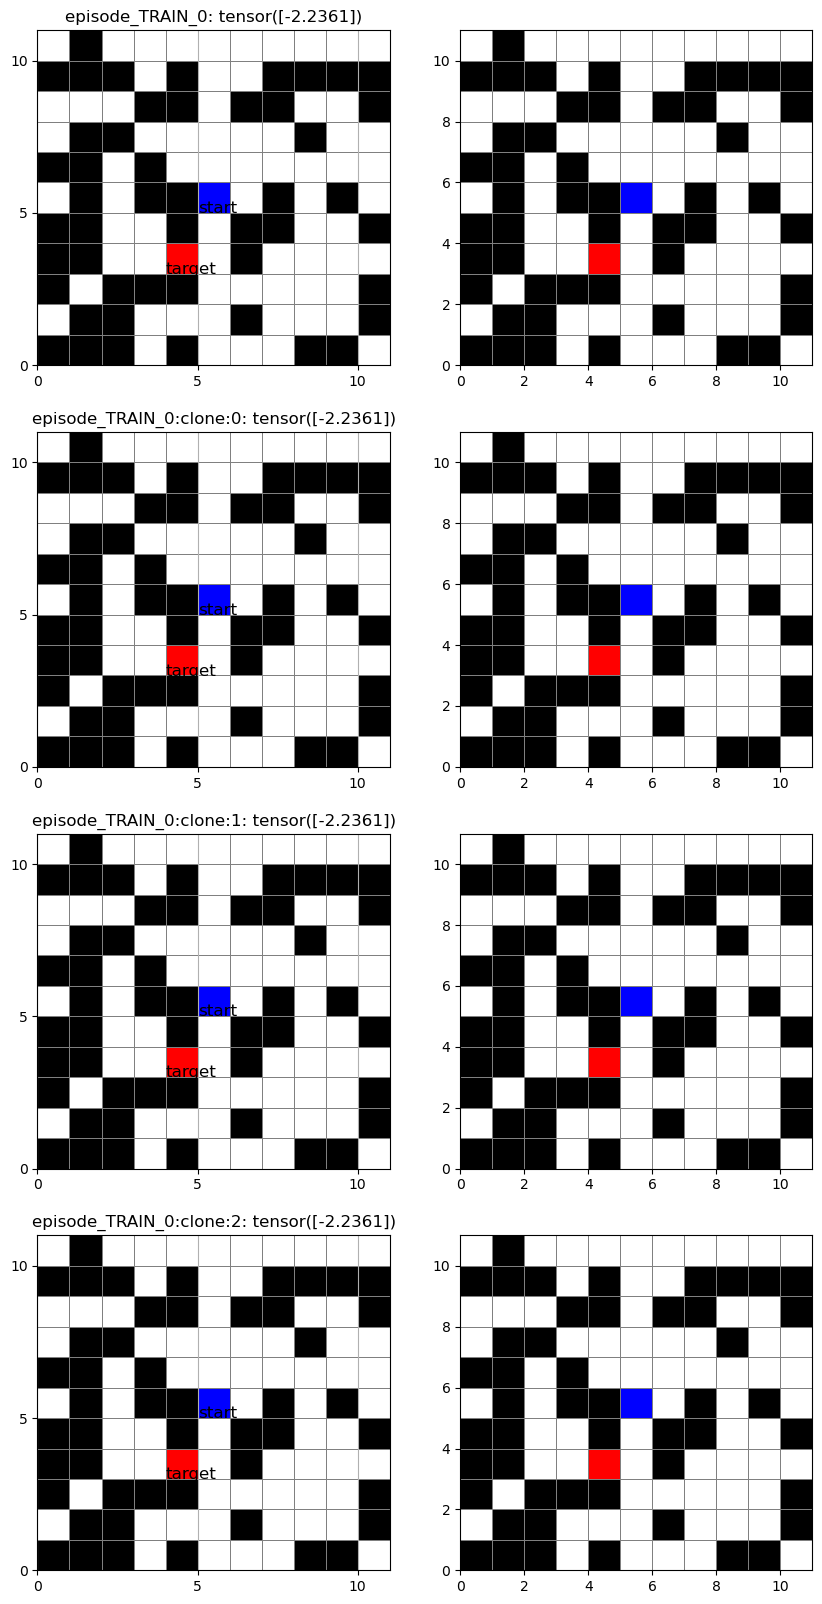

In [4]:
episode_samples = 4
fig, axes = plt.subplots(nrows=episode_samples, ncols=2, figsize=(10, 20))

for eidx in range(episode_samples):
    es = train_dataset.get_episode(eidx)

    es.viz(ax=axes[eidx][0], reward_model=reward_model)

    # Viz fov
    fov = es.fov(center_pos=es.agent.start_state.position())
    # print(f"fov: {fov.size()}, {fov}")
    # print(f"fov: {fov}")
    es.viz_fov(ax=axes[eidx][1])
plt.show()

# Training Loop
---

In [5]:
policy = PolicyFactory.create(
    policy_mode=PolicyMode.TRANSFORMER_WITH_LATE_POSITION_FUSION, config=config
).to(config.device)
reward_model = RewardModel(config=config)
trainer = GRPOTrainer(config=config, policy=policy, reward_model=reward_model)

TEST:  16%|█▌        | 12/75 [00:00<00:02, 23.35it/s]

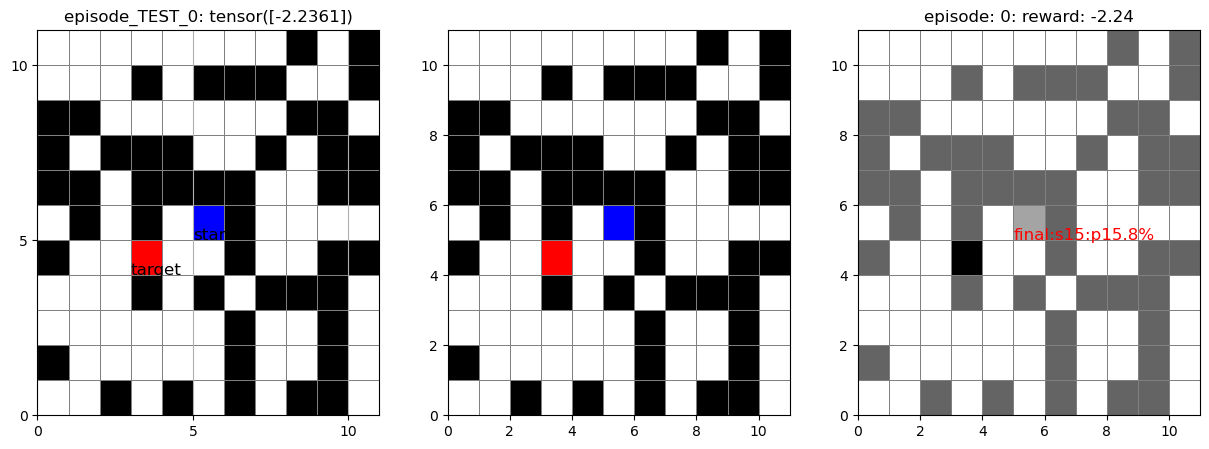

TEST:  39%|███▊      | 29/75 [00:01<00:02, 21.55it/s, split=TEST, batch_idx=14, is_episode_step_done=1, target_episodes=['episode_TEST_0', 'episode_TEST_0:clone:0', 'episode_TEST_0:clone:1', 'episode_TEST_0:clone:2', 'episode_TEST_0:clone:3', 'episode_TEST_0:clone:4', 'episode_TEST_0:clone:5', 'episode_TEST_0:clone:6', 'episode_TEST_0:clone:7', 'episode_TEST_0:clone:8', 'episode_TEST_0:clone:9', 'episode_TEST_0:clone:10', 'episode_TEST_0:clone:11', 'episode_TEST_0:clone:12', 'episode_TEST_0:clone:13', 'episode_TEST_0:clone:14', 'episode_TEST_0:clone:15', 'episode_TEST_0:clone:16', 'episode_TEST_0:clone:17', 'episode_TEST_0:clone:18', 'episode_TEST_0:clone:19', 'episode_TEST_0:clone:20', 'episode_TEST_0:clone:21', 'episode_TEST_0:clone:22', 'episode_TEST_0:clone:23', 'episode_TEST_0:clone:24', 'episode_TEST_0:clone:25', 'episode_TEST_0:clone:26', 'episode_TEST_0:clone:27', 'episode_TEST_0:clone:28', 'episode_TEST_0:clone:29', 'episode_TEST_0:clone:30', 'episode_TEST_0:clone:31', 'episod

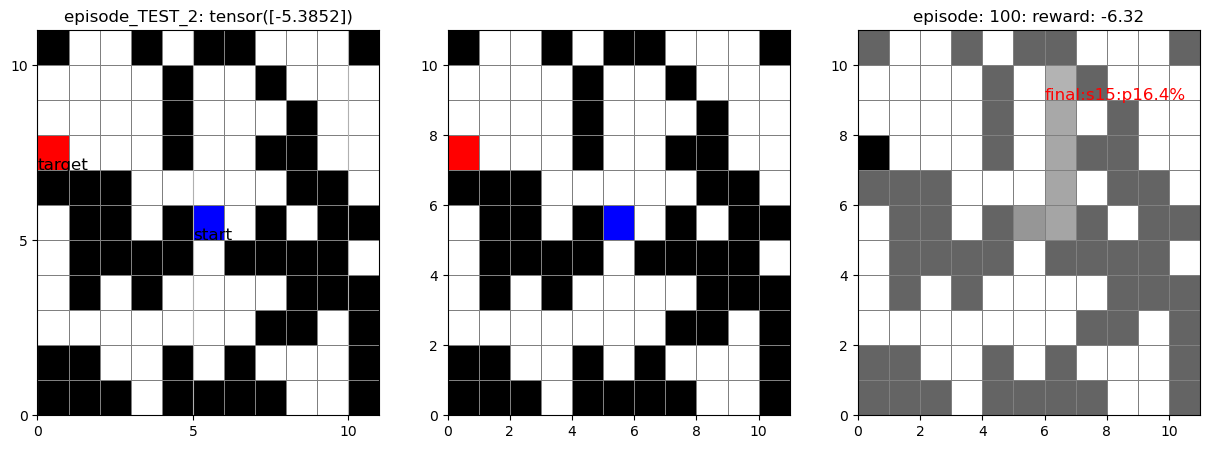

TEST:  59%|█████▊    | 44/75 [00:02<00:01, 22.33it/s, split=TEST, batch_idx=29, is_episode_step_done=1, target_episodes=['episode_TEST_2', 'episode_TEST_2:clone:0', 'episode_TEST_2:clone:1', 'episode_TEST_2:clone:2', 'episode_TEST_2:clone:3', 'episode_TEST_2:clone:4', 'episode_TEST_2:clone:5', 'episode_TEST_2:clone:6', 'episode_TEST_2:clone:7', 'episode_TEST_2:clone:8', 'episode_TEST_2:clone:9', 'episode_TEST_2:clone:10', 'episode_TEST_2:clone:11', 'episode_TEST_2:clone:12', 'episode_TEST_2:clone:13', 'episode_TEST_2:clone:14', 'episode_TEST_2:clone:15', 'episode_TEST_2:clone:16', 'episode_TEST_2:clone:17', 'episode_TEST_2:clone:18', 'episode_TEST_2:clone:19', 'episode_TEST_2:clone:20', 'episode_TEST_2:clone:21', 'episode_TEST_2:clone:22', 'episode_TEST_2:clone:23', 'episode_TEST_2:clone:24', 'episode_TEST_2:clone:25', 'episode_TEST_2:clone:26', 'episode_TEST_2:clone:27', 'episode_TEST_2:clone:28', 'episode_TEST_2:clone:29', 'episode_TEST_2:clone:30', 'episode_TEST_2:clone:31', 'episod

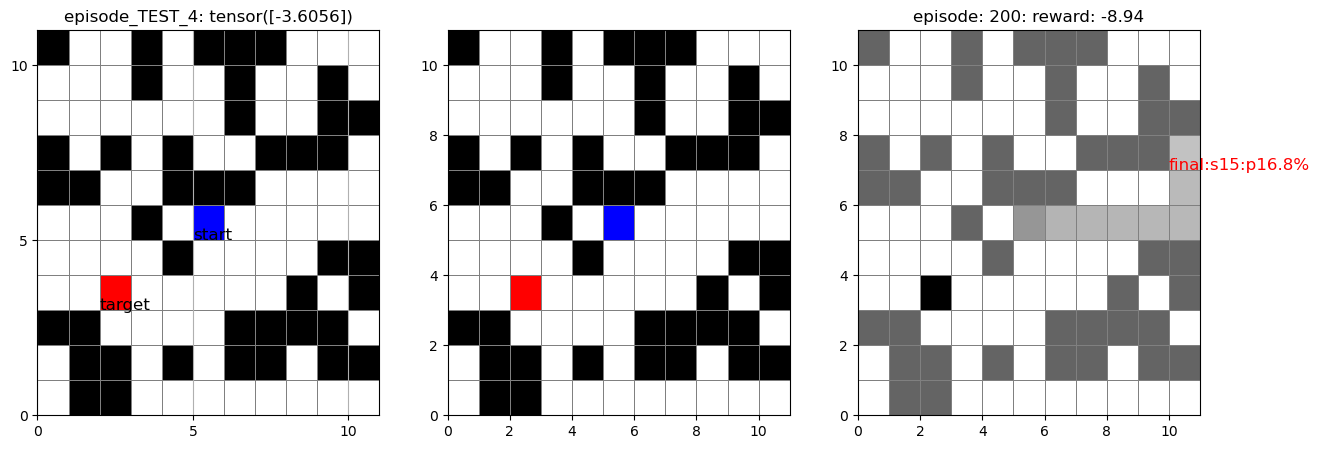

TEST:  79%|███████▊  | 59/75 [00:02<00:00, 22.40it/s, split=TEST, batch_idx=44, is_episode_step_done=1, target_episodes=['episode_TEST_4', 'episode_TEST_4:clone:0', 'episode_TEST_4:clone:1', 'episode_TEST_4:clone:2', 'episode_TEST_4:clone:3', 'episode_TEST_4:clone:4', 'episode_TEST_4:clone:5', 'episode_TEST_4:clone:6', 'episode_TEST_4:clone:7', 'episode_TEST_4:clone:8', 'episode_TEST_4:clone:9', 'episode_TEST_4:clone:10', 'episode_TEST_4:clone:11', 'episode_TEST_4:clone:12', 'episode_TEST_4:clone:13', 'episode_TEST_4:clone:14', 'episode_TEST_4:clone:15', 'episode_TEST_4:clone:16', 'episode_TEST_4:clone:17', 'episode_TEST_4:clone:18', 'episode_TEST_4:clone:19', 'episode_TEST_4:clone:20', 'episode_TEST_4:clone:21', 'episode_TEST_4:clone:22', 'episode_TEST_4:clone:23', 'episode_TEST_4:clone:24', 'episode_TEST_4:clone:25', 'episode_TEST_4:clone:26', 'episode_TEST_4:clone:27', 'episode_TEST_4:clone:28', 'episode_TEST_4:clone:29', 'episode_TEST_4:clone:30', 'episode_TEST_4:clone:31', 'episod

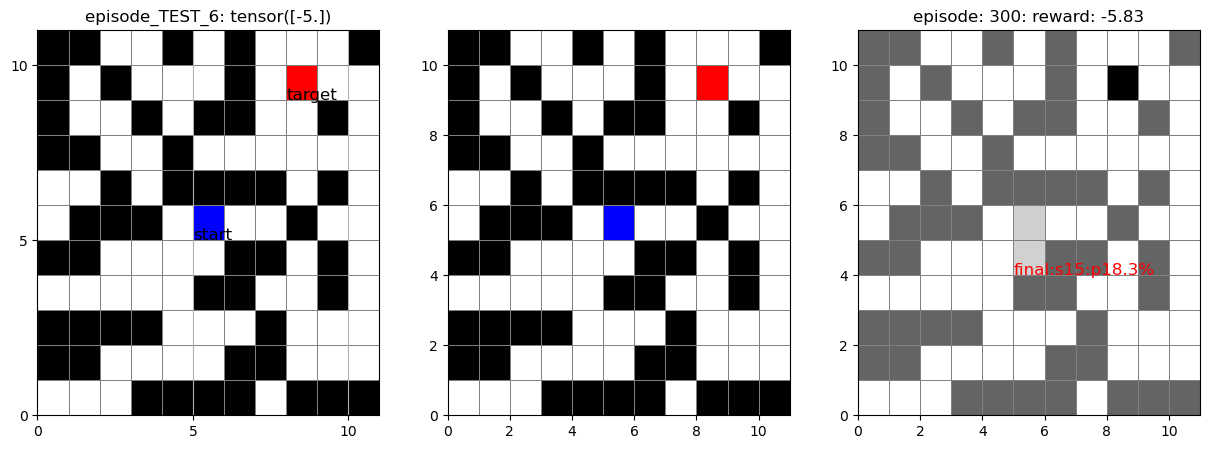

TEST:  99%|█████████▊| 74/75 [00:03<00:00, 22.59it/s, split=TEST, batch_idx=59, is_episode_step_done=1, target_episodes=['episode_TEST_6', 'episode_TEST_6:clone:0', 'episode_TEST_6:clone:1', 'episode_TEST_6:clone:2', 'episode_TEST_6:clone:3', 'episode_TEST_6:clone:4', 'episode_TEST_6:clone:5', 'episode_TEST_6:clone:6', 'episode_TEST_6:clone:7', 'episode_TEST_6:clone:8', 'episode_TEST_6:clone:9', 'episode_TEST_6:clone:10', 'episode_TEST_6:clone:11', 'episode_TEST_6:clone:12', 'episode_TEST_6:clone:13', 'episode_TEST_6:clone:14', 'episode_TEST_6:clone:15', 'episode_TEST_6:clone:16', 'episode_TEST_6:clone:17', 'episode_TEST_6:clone:18', 'episode_TEST_6:clone:19', 'episode_TEST_6:clone:20', 'episode_TEST_6:clone:21', 'episode_TEST_6:clone:22', 'episode_TEST_6:clone:23', 'episode_TEST_6:clone:24', 'episode_TEST_6:clone:25', 'episode_TEST_6:clone:26', 'episode_TEST_6:clone:27', 'episode_TEST_6:clone:28', 'episode_TEST_6:clone:29', 'episode_TEST_6:clone:30', 'episode_TEST_6:clone:31', 'episod

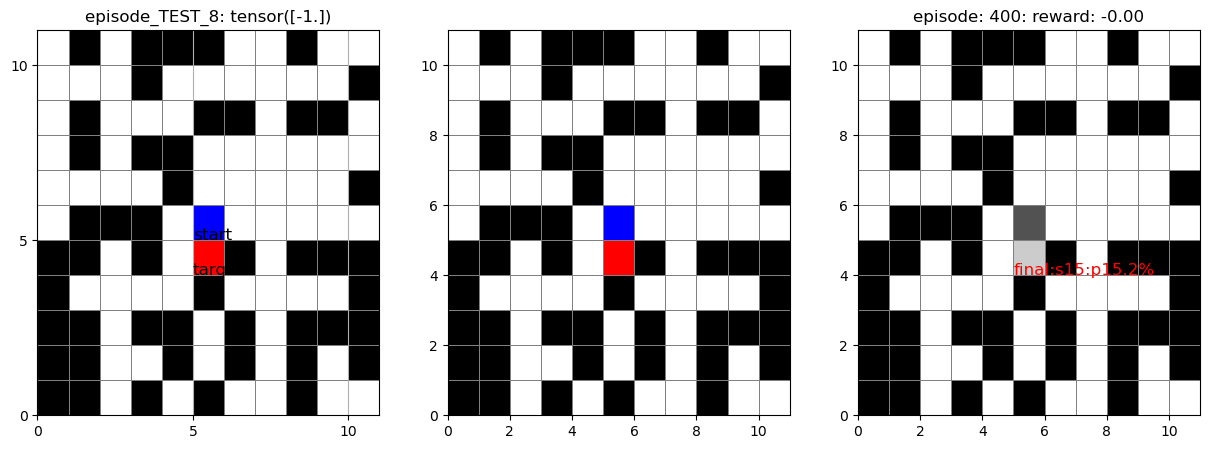

TEST: 100%|██████████| 75/75 [00:03<00:00, 19.95it/s, split=TEST, batch_idx=74, is_episode_step_done=1, target_episodes=['episode_TEST_8', 'episode_TEST_8:clone:0', 'episode_TEST_8:clone:1', 'episode_TEST_8:clone:2', 'episode_TEST_8:clone:3', 'episode_TEST_8:clone:4', 'episode_TEST_8:clone:5', 'episode_TEST_8:clone:6', 'episode_TEST_8:clone:7', 'episode_TEST_8:clone:8', 'episode_TEST_8:clone:9', 'episode_TEST_8:clone:10', 'episode_TEST_8:clone:11', 'episode_TEST_8:clone:12', 'episode_TEST_8:clone:13', 'episode_TEST_8:clone:14', 'episode_TEST_8:clone:15', 'episode_TEST_8:clone:16', 'episode_TEST_8:clone:17', 'episode_TEST_8:clone:18', 'episode_TEST_8:clone:19', 'episode_TEST_8:clone:20', 'episode_TEST_8:clone:21', 'episode_TEST_8:clone:22', 'episode_TEST_8:clone:23', 'episode_TEST_8:clone:24', 'episode_TEST_8:clone:25', 'episode_TEST_8:clone:26', 'episode_TEST_8:clone:27', 'episode_TEST_8:clone:28', 'episode_TEST_8:clone:29', 'episode_TEST_8:clone:30', 'episode_TEST_8:clone:31', 'episod

In [6]:
inference_and_plot_policy_v2(
    config=config,
    dataset=test_dataset,
    dataloader=test_dataloader,
    policy=policy,
    reward_model=reward_model,
    top_k=2,
)

In [ ]:
# plt.ioff()
trainer.run(train_dataset=train_dataset, eval_dataset=eval_dataset, debug=False)
save_policy_model(policy=policy)

# plt.ion()

train_dataloader: 3000, eval_dataloader: 75


Epoch 1:  40%|████      | 1203/3000 [2:01:49<1:57:59,  3.94s/it, split=TRAIN, step=80, batch_idx=1202, is_episode_step_done=0]   

# Evaluate the Model
----

In [ ]:
inference_and_plot_policy_v2(
    config=config,
    dataset=test_dataset,
    dataloader=test_dataloader,
    policy=policy,
    reward_model=reward_model,
    top_k=1,
)

In [ ]:
inference_and_plot_policy_v2(
    config=config,
    dataset=test_dataset,
    dataloader=test_dataloader,
    policy=policy,
    reward_model=reward_model,
    top_k=2,
)

In [ ]:
# policy_model_path = (
#     "/Users/chengbai/ml/cheng_git/rf_agent/rf_model_policy_20250510230738_base.pt"
# )
# trained_policy = load_policy_model(config=config, policy_model_path=policy_model_path)
# assert trained_policy is not None

# episode = inference_and_plot_policy(
#     policy=trained_policy, config=config, reward_model=reward_model, steps=5, debug=True
# )